[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/InCLow/ik-nlp-tutorials/blob/main/notebooks/W2T_Transformers_Architecture.ipynb)

**This is a notebook on implementation details of Transformers architectures adapted from the [Harvard NLP course](https://nlp.seas.harvard.edu/annotated-transformer/). Thanks to [Jirui Qi](https://betswish.github.io/) for taking charge of the edition job.**

> 💡 **If you aren't / used to be familiar with Transformers, here is a nice channel helping you recall the knowledge:
https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi**

# Transformers, from scratch (a simplified notebook)

This notebook is a **from-scratch, minimal** introduction to the Transformer architecture (encoder–decoder) from

*[Attention Is All You Need (213087 citations, Nieurips 2017)](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)*.

### Learning goals
By the end, you should be able to:
- Explain **self-attention** using **Q, K, V** and the **scaled dot-product** formula
- Describe why we need **positional information**
- Understand what **multi-head attention** does and why it helps
- Read (and write) a small Transformer forward pass in PyTorch

### What this notebook is *not*
- It is **not** a full training recipe for state-of-the-art translation.
- It is **not** optimized for speed; it’s optimized for clarity.



## 0) Setup

We only need PyTorch + matplotlib.
If you're running this on Colab, you can uncomment the install cell.

In [ ]:
# Uncomment if needed (e.g., fresh Colab):
# !pip -q install torch matplotlib

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


## 1) The big picture: Encoder–Decoder


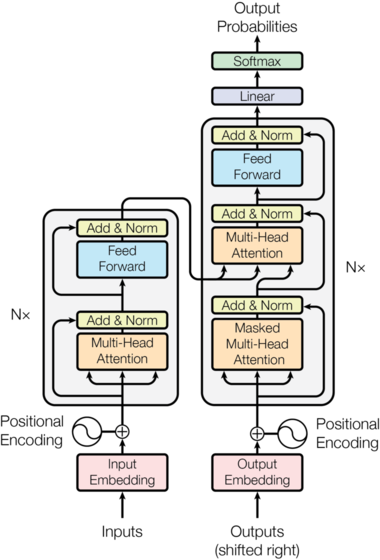


A **Transformer** (in the original paper) has two stacks:

- **Encoder**: reads an input sequence and builds contextual representations.
- **Decoder**: generates an output sequence token-by-token, attending to:
  1) previous output tokens (**masked self-attention**), and  
  2) the encoder outputs (**cross-attention**).

Each stack is made from repeated **blocks**:

**Encoder block**
1. Self-attention
2. Feed-forward network (FFN)

**Decoder block**
1. Masked self-attention
2. Cross-attention (decoder → encoder)
3. Feed-forward network (FFN)

Every sublayer is wrapped by:
- **Residual connection**: `x + sublayer(x)`
- **LayerNorm**

## 2) Tokens → Embeddings

Transformers operate on vectors, not raw token IDs.
So we use an **embedding table** to map token IDs to vectors of size `d_model`.

Below we build a tiny toy vocabulary and look at shapes.

In [ ]:
# A tiny toy "vocab"
vocab = {
    "<pad>": 0,
    "Today": 1,
    "we": 2,
    "studied": 3,
    "the": 4,
    "Transformers": 5,
    "architecture": 6,
    ":": 7,
    "layer": 8,
    "paths": 9,
    ",": 10,
    "and": 11,
    "residual": 12,
    "positional": 13,
    "encoding": 14,
    ".": 15,
}
inv_vocab = {i: t for t, i in vocab.items()}


d_model = 32
embed = nn.Embedding(num_embeddings=len(vocab), embedding_dim=d_model).to(device)

sentence = [
    "Today",
    "we",
    "studied",
    "the",
    "Transformers",
    "architecture",
    ":",
    "layer",
    "paths",
    ",",
    "residual",
    "paths",
    ",",
    "and",
    "positional",
    "encoding",
    "."
]
x_ids = torch.tensor([[vocab[t] for t in sentence]], device=device)  # (batch=1, seq_len=4)
x = embed(x_ids)  # (1, 4, d_model)

print("token ids:", x_ids)
print("embedding shape:", x.shape)
# print("token embeddings:", x)

token ids: tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12,  9, 10, 11, 13, 14, 15]])
embedding shape: torch.Size([1, 17, 32])


### Check your understanding
- What does the embedding matrix store?
- How would you handle unknown words in a real system?

## 3) Positional information (why and how)

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned or fixed ([cite](https://arxiv.org/pdf/1705.03122)).

In this work, we use sine and cosine functions of different frequencies

\begin{aligned}
{\rm PE}(pos, 2i) &= \sin\left(pos / 10000^{2i/d_{model}}\right)\\
{\rm PE}(pos, 2i+1) &= \cos\left(pos / 10000^{2i/d_{model}}\right)
\end{aligned}

where $pos$ is the position and $2i$ / $2i+1$ are the dimensions in $|d_{model}|$. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths $\lambda = 2\pi / (1 / 10000^{2i/d_{model}}) = 2\pi \cdot 10000^{2i/d_{model}}$ form a geometric progression from $2\pi$ to ~$2\pi \cdot 10000$ ($i = 0, 1, \ldots, d_{model}/2-1$). We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, ${\rm PE}_{pos+k}$ can be represented as a linear function of ${\rm PE}_{pos}$.



In [ ]:
def sinusoidal_positional_encoding(seq_len: int, d_model: int, device=None) -> torch.Tensor:
    # Returns a (1, seq_len, d_model) tensor you can add to embeddings.
    device = device or "cpu"
    pos = torch.arange(seq_len, device=device).float().unsqueeze(1)  # (seq_len, 1)
    j = torch.arange(d_model, device=device).float().unsqueeze(0)    # (1, d_model), we assign j for easier Implementation, where j // 2 == i

    angle_rates = 1.0 / (10000 ** (2 * (j // 2) / d_model))          # (1, d_model)
    angles = pos * angle_rates                                       # (seq_len, d_model)

    pe = torch.zeros(seq_len, d_model, device=device)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe.unsqueeze(0)                                           # (1, seq_len, d_model)

seq_len = x.shape[1]
pe = sinusoidal_positional_encoding(seq_len=seq_len, d_model=d_model, device=device)
x_pos = x + pe

print("positional encoding shape:", pe.shape)
print("x_pos shape:", x_pos.shape)
# print(x_pos)
# print(pe)

positional encoding shape: torch.Size([1, 17, 32])
x_pos shape: torch.Size([1, 17, 32])


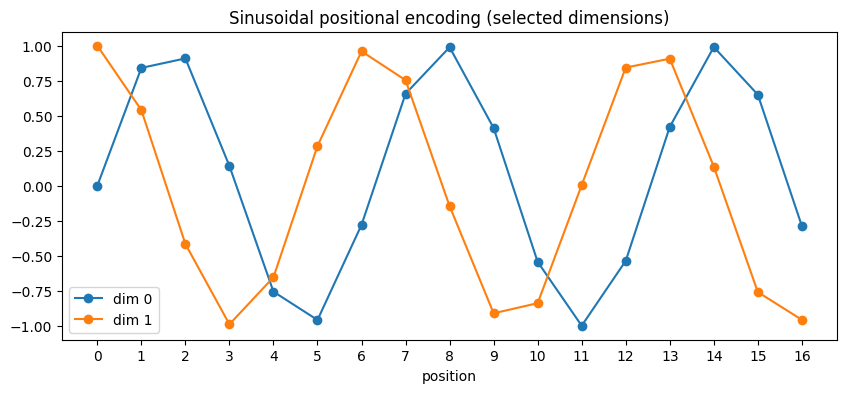

In [ ]:
# Plot a few dimensions of PE across positions
pe_cpu = pe[0].detach().cpu()  # (seq_len, d_model)

plt.figure(figsize=(10, 4))
for dim in [0, 1]:
    plt.plot(pe_cpu[:, dim], marker="o", label=f"dim {dim}")
plt.title("Sinusoidal positional encoding (selected dimensions)")
plt.xlabel("position")
plt.xticks(range(pe_cpu.shape[0]))

plt.legend()
plt.show()

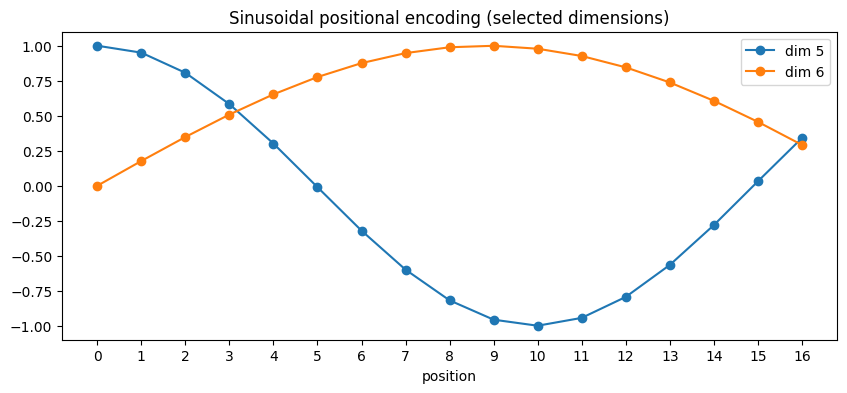

In [ ]:

plt.figure(figsize=(10, 4))
for dim in [5, 6]:
    plt.plot(pe_cpu[:, dim], marker="o", label=f"dim {dim}")
plt.title("Sinusoidal positional encoding (selected dimensions)")
plt.xlabel("position")
plt.xticks(range(pe_cpu.shape[0]))

plt.legend()

plt.show()

### Check your understanding
- Why does adding `PE` to embeddings make sense (instead of concatenating)?
- What happens if we feed longer sequences than we trained on?

## 4) Scaled dot-product attention (the core operation)

Attention takes **queries (Q)**, **keys (K)**, and **values (V)**.

Intuition:
- Compare each query to all keys (similarity scores)
- Turn scores into a probability distribution (softmax)
- Use probabilities to mix the values

Formula (for one head):

\begin{aligned}
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
\end{aligned}

We include an optional **mask**:
- To ignore padding tokens
- To prevent the decoder from seeing the future (look-ahead mask)

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Q: (B, Tq, d_k)
    # K: (B, Tk, d_k)
    # V: (B, Tk, d_v)  (usually d_v == d_k)
    # mask: (B, Tq, Tk) with 1 for allowed, 0 for disallowed (or None)
    # returns:
    #   out:  (B, Tq, d_v)
    #   attn: (B, Tq, Tk) attention weights
    d_k = Q.size(-1)
    scores = (Q @ K.transpose(-2, -1)) / math.sqrt(d_k)  # (B, Tq, Tk)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attn = F.softmax(scores, dim=-1)                     # (B, Tq, Tk)
    out = attn @ V                                       # (B, Tq, d_v)
    return out, attn

# Quick sanity check
B, T, d_k = 2, 4, 8
Q = torch.randn(B, T, d_k)
K = torch.randn(B, T, d_k)
V = torch.randn(B, T, d_k)

out, attn = scaled_dot_product_attention(Q, K, V)
print("out:", out.shape, "attn:", attn.shape)
print("attn row sums (should be 1):", attn[0, 0].sum().item())

out: torch.Size([2, 4, 8]) attn: torch.Size([2, 4, 4])
attn row sums (should be 1): 1.0


### Visualizing attention weights on a toy example

We’ll create Q, K, V from embeddings using linear projections, then visualize the attention matrix.

In [ ]:
# Make a single-head self-attention example (B=1)
x = x_pos.detach()  # (1, T=4, d_model)

d_k = 16
Wq = nn.Linear(d_model, d_k, bias=False).to(device)
Wk = nn.Linear(d_model, d_k, bias=False).to(device)
Wv = nn.Linear(d_model, d_k, bias=False).to(device)

Q = Wq(x)
K = Wk(x)
V = Wv(x)

out, attn = scaled_dot_product_attention(Q, K, V)  # attn: (1, T, T)
print("attention matrix shape:", attn.shape)

attention matrix shape: torch.Size([1, 17, 17])


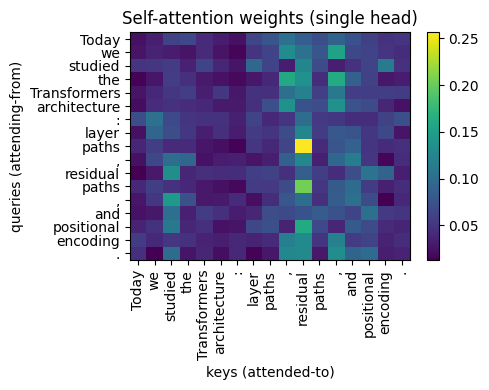

In [ ]:
# Plot attention heatmap
attn_cpu = attn[0].detach().cpu()  # (T, T)
tokens = sentence

plt.figure(figsize=(5, 4))
plt.imshow(attn_cpu, aspect="auto")
plt.xticks(range(len(tokens)), tokens, rotation=90, ha="center")
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title("Self-attention weights (single head)")
plt.xlabel("keys (attended-to)")
plt.ylabel("queries (attending-from)")
plt.tight_layout()
plt.show()

### Check your understanding
- Why is the softmax over the **key** dimension?
- What does an entry `attn[i, j]` mean in words?

## 5) Masks: padding mask and look-ahead mask

Two common masks:
1) **Padding mask**: ignore `<pad>` tokens in attention.
2) **Look-ahead (causal) mask**: in the decoder, position *t* cannot attend to positions > *t*.

We’ll implement the causal mask used by the decoder’s masked self-attention.

In [ ]:
def causal_mask(seq_len: int, device=None) -> torch.Tensor:
    # Returns (1, seq_len, seq_len) where 1 means "allowed to attend".
    device = device or "cpu"
    m = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return m.unsqueeze(0)  # (1, T, T)

T = 6
m = causal_mask(T)
print(m[0].int())

tensor([[1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]], dtype=torch.int32)


### Mini-exercise
Modify `scaled_dot_product_attention` so it also supports a padding mask shaped `(B, 1, Tk)`
(i.e., broadcasting over queries).

## 6) Multi-head self-attention (why multiple heads?)

Instead of one attention calculation, we run `h` **heads** in parallel.

Each head has its own projections, then we concatenate head outputs and project back to `d_model`.

Below is a compact, readable implementation for **self-attention**.

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.Wo = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def split_heads(self, x):
        # x: (B, T, d_model) -> (B, h, T, d_head)
        B, T, _ = x.shape
        x = x.view(B, T, self.num_heads, self.d_head)
        return x.transpose(1, 2)

    def combine_heads(self, x):
        # x: (B, h, T, d_head) -> (B, T, d_model)
        B, h, T, d_head = x.shape
        x = x.transpose(1, 2).contiguous().view(B, T, h * d_head)
        return x

    def forward(self, x, mask=None, return_attention=False):
        Q = self.split_heads(self.Wq(x))
        K = self.split_heads(self.Wk(x))
        V = self.split_heads(self.Wv(x))
        # (B, h, T, d_head)

        B, h, T, d = Q.shape
        Q2 = Q.reshape(B * h, T, d)
        K2 = K.reshape(B * h, T, d)
        V2 = V.reshape(B * h, T, d)

        if mask is not None:
            mask2 = mask.repeat_interleave(h, dim=0)  # (B*h, T, T)
        else:
            mask2 = None

        out2, attn2 = scaled_dot_product_attention(Q2, K2, V2, mask=mask2)
        out = out2.reshape(B, h, T, d)
        out = self.combine_heads(out)
        out = self.Wo(out)
        out = self.dropout(out)

        if return_attention:
            attn = attn2.reshape(B, h, T, T)
            return out, attn
        return out

mha = MultiHeadSelfAttention(d_model=32, num_heads=4).to(device)
y, attn_h = mha(x_pos, return_attention=True)
print("output shape:", y.shape)
print("per-head attn shape:", attn_h.shape)

output shape: torch.Size([1, 17, 32])
per-head attn shape: torch.Size([1, 4, 17, 17])


### Visualize one head

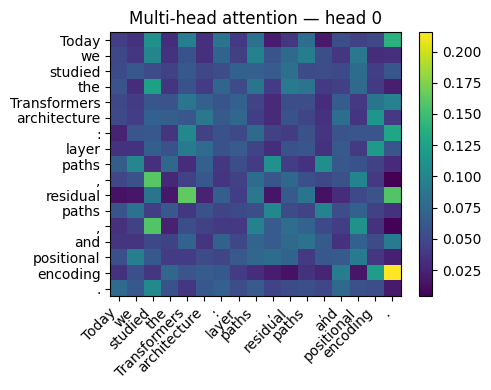

In [ ]:
head = 0
attn0 = attn_h[0, head].detach().cpu()  # (T, T)

plt.figure(figsize=(5, 4))
plt.imshow(attn0, aspect="auto")
plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title(f"Multi-head attention — head {head}")
plt.tight_layout()
plt.show()

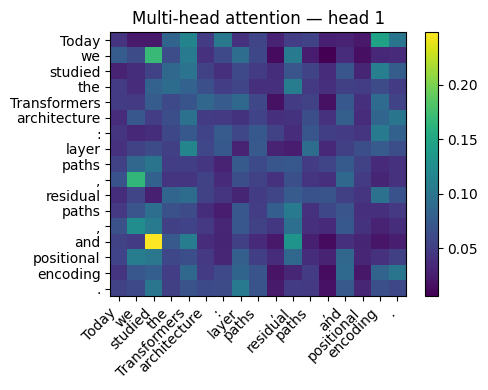

In [ ]:
head = 1
attn0 = attn_h[0, head].detach().cpu()  # (T, T)

plt.figure(figsize=(5, 4))
plt.imshow(attn0, aspect="auto")
plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title(f"Multi-head attention — head {head}")
plt.tight_layout()
plt.show()

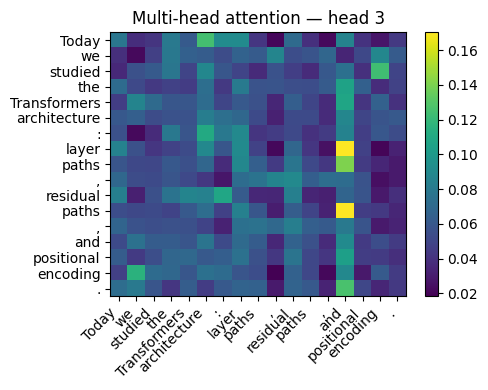

In [ ]:
head = 3
attn0 = attn_h[0, head].detach().cpu()  # (T, T)

plt.figure(figsize=(5, 4))
plt.imshow(attn0, aspect="auto")
plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title(f"Multi-head attention — head {head}")
plt.tight_layout()
plt.show()

### Check your understanding
- What changes when we increase the number of heads?
- Why do we scale by `sqrt(d_k)` in the attention score?

## 7) The rest of a Transformer block: FFN + Add & Norm

Each block contains:
1) Attention sublayer
2) Position-wise feed-forward network (FFN)

We also use:
- Residual connections
- LayerNorm
- (Optional) dropout

In [ ]:
class PositionwiseFFN(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        return self.net(x)

class ResidualLayerNorm(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_out):
        return self.ln(x + self.dropout(sublayer_out))

ffn = PositionwiseFFN(d_model=32, d_ff=64).to(device)
rl = ResidualLayerNorm(d_model=32).to(device)

tmp = mha(x_pos)
y = rl(x_pos, tmp)
z = rl(y, ffn(y))
print("block output shape:", z.shape)

block output shape: torch.Size([1, 17, 32])


## 8) Encoder block + Encoder stack

An **encoder block** is:
- self-attention
- FFN
(with residual + LayerNorm around each)

We now assemble an encoder stack of `N` blocks.

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads, dropout=dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)
        self.res1 = ResidualLayerNorm(d_model, dropout=dropout)
        self.res2 = ResidualLayerNorm(d_model, dropout=dropout)

    def forward(self, x, src_mask=None):
        attn_out = self.self_attn(x, mask=src_mask)
        x = self.res1(x, attn_out)
        ffn_out = self.ffn(x)
        x = self.res2(x, ffn_out)
        return x

class Encoder(nn.Module):
    def __init__(self, N: int, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(N)])

    def forward(self, x, src_mask=None):
        for layer in self.layers:
            x = layer(x, src_mask=src_mask)
        return x

enc = Encoder(N=2, d_model=32, num_heads=4, d_ff=64).to(device)
enc_out = enc(x_pos)
print("encoder output shape:", enc_out.shape)

encoder output shape: torch.Size([1, 17, 32])


### Check your understanding
- Why do we apply the FFN “position-wise” (same weights for every position)?

## 9) Decoder block (masked self-attention + cross-attention)

Decoder adds two ideas:
1) **Masked self-attention** over the *target so far* (causal mask)
2) **Cross-attention**: queries from decoder, keys/values from encoder outputs

We'll implement a readable cross-attention module by reusing our attention code
with separate `q` and `kv` inputs.

In [ ]:
class MultiHeadAttention(nn.Module):
    # General multi-head attention: Q from x_q; K,V from x_kv
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.Wo = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def split_heads(self, x):
        B, T, _ = x.shape
        return x.view(B, T, self.num_heads, self.d_head).transpose(1, 2)  # (B, h, T, d_head)

    def combine_heads(self, x):
        B, h, T, d = x.shape
        return x.transpose(1, 2).contiguous().view(B, T, h * d)

    def forward(self, x_q, x_kv, mask=None):
        Q = self.split_heads(self.Wq(x_q))
        K = self.split_heads(self.Wk(x_kv))
        V = self.split_heads(self.Wv(x_kv))

        B, h, Tq, d = Q.shape
        Tk = K.shape[2]

        Q2 = Q.reshape(B * h, Tq, d)
        K2 = K.reshape(B * h, Tk, d)
        V2 = V.reshape(B * h, Tk, d)

        if mask is not None:
            mask2 = mask.repeat_interleave(h, dim=0)
        else:
            mask2 = None

        out2, _ = scaled_dot_product_attention(Q2, K2, V2, mask=mask2)
        out = out2.reshape(B, h, Tq, d)
        out = self.combine_heads(out)
        out = self.Wo(out)
        out = self.dropout(out)
        return out

class DecoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)

        self.res1 = ResidualLayerNorm(d_model, dropout=dropout)
        self.res2 = ResidualLayerNorm(d_model, dropout=dropout)
        self.res3 = ResidualLayerNorm(d_model, dropout=dropout)

    def forward(self, y, enc_out, tgt_mask=None, memory_mask=None):
        sa = self.self_attn(y, y, mask=tgt_mask)
        y = self.res1(y, sa)

        ca = self.cross_attn(y, enc_out, mask=memory_mask)
        y = self.res2(y, ca)

        f = self.ffn(y)
        y = self.res3(y, f)
        return y

## 10) A tiny full Transformer (forward pass only)

We’ll assemble:
- token embedding + positional encoding
- encoder stack
- decoder stack
- final linear layer to predict next-token logits

This is enough to understand tensor shapes and where masks go.

In [ ]:
class TransformerTiny(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_heads: int, d_ff: int, N: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        self.encoder = Encoder(N=N, d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
        self.decoder_layers = nn.ModuleList([DecoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(N)])
        self.out = nn.Linear(d_model, vocab_size)

    def add_positional_encoding(self, x):
        B, T, d = x.shape
        pe = sinusoidal_positional_encoding(T, d, device=x.device)
        return x + pe

    def forward(self, src_ids, tgt_ids):
        # src_ids: (B, S)
        # tgt_ids: (B, T)  (teacher-forcing inputs; in real training, shift right)
        B, S = src_ids.shape
        _, T = tgt_ids.shape

        src = self.add_positional_encoding(self.embed(src_ids))
        tgt = self.add_positional_encoding(self.embed(tgt_ids))

        # Causal mask for decoder self-attention only (no padding in this toy)
        tgt_mask = causal_mask(T, device=src_ids.device).repeat(B, 1, 1)  # (B, T, T)

        enc_out = self.encoder(src)  # (B, S, d_model)

        y = tgt
        for layer in self.decoder_layers:
            y = layer(y, enc_out, tgt_mask=tgt_mask, memory_mask=None)

        logits = self.out(y)  # (B, T, vocab_size)
        return logits

model = TransformerTiny(vocab_size=len(vocab), d_model=32, num_heads=4, d_ff=64, N=2).to(device)

src_ids = x_ids  # (1, 4)
tgt_ids = x_ids  # (1, 4)

logits = model(src_ids, tgt_ids)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

logits shape: torch.Size([1, 17, 16])


### Interpreting logits
`logits[b, t]` is a vector of length `vocab_size` with scores for the token at position `t`.

To turn it into probabilities, apply softmax.

In [ ]:
probs = F.softmax(logits[0, -1], dim=-1).detach().cpu()
topk = torch.topk(probs, k=min(5, len(vocab)))
print("Top predictions for the last position:")
for p, idx in zip(topk.values, topk.indices):
    print(f"  {inv_vocab[int(idx)] :>6s}  prob={float(p):.3f}")

Top predictions for the last position:
  Transformers  prob=0.220
  architecture  prob=0.132
  studied  prob=0.099
     and  prob=0.077
  residual  prob=0.064


## 11) Optional: a tiny “copy task” training demo (very small)

If time allows, we can train a Transformer to copy random token sequences.
This is a classic sanity-check exercise.

**Note:** This is intentionally small and not a benchmark.

step   50  loss=0.169
step  100  loss=0.044
step  150  loss=0.022
step  200  loss=0.013


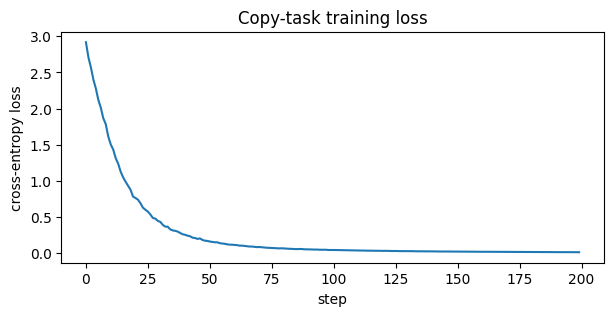

In [ ]:
# A minimal copy-task dataset: sequences of IDs (excluding <pad>)
def sample_batch(batch_size: int, seq_len: int, vocab_size: int, device=None):
    device = device or "cpu"
    # tokens in [1, vocab_size-1]
    src = torch.randint(1, vocab_size, (batch_size, seq_len), device=device)
    # For a real decoder, you'd shift the target right with a <bos> token.
    # For teaching, we keep it simple: input to decoder = src, target = src.
    tgt_in = src.clone()
    tgt_out = src.clone()
    return src, tgt_in, tgt_out

def train_copy_demo(steps=200, batch_size=32, seq_len=6, lr=2e-3):
    demo_model = TransformerTiny(vocab_size=len(vocab), d_model=32, num_heads=4, d_ff=64, N=2).to(device)
    opt = torch.optim.Adam(demo_model.parameters(), lr=lr)
    losses = []

    for step in range(steps):
        src, tgt_in, tgt_out = sample_batch(batch_size, seq_len, len(vocab), device=device)
        logits = demo_model(src, tgt_in)  # (B, T, V)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(float(loss.detach().cpu()))
        if (step + 1) % 50 == 0:
            print(f"step {step+1:4d}  loss={losses[-1]:.3f}")

    plt.figure(figsize=(7, 3))
    plt.plot(losses)
    plt.title("Copy-task training loss")
    plt.xlabel("step")
    plt.ylabel("cross-entropy loss")
    plt.show()

train_copy_demo(steps=200)

## 12) Summary

1) **Self-attention** mixes information across positions using similarity of Q and K, applied to V.  
2) **Multi-head attention** lets the model attend to multiple patterns in parallel.  
3) **Positional encoding** provides order information since attention itself is permutation-invariant.  
4) A Transformer block = attention + FFN, each wrapped by residual + LayerNorm.  
5) Decoder differs from encoder by using **causal masking** and **cross-attention**.

### Suggested exercises
- Implement a **padding mask** and verify that attention ignores `<pad>`.
- Add a `<bos>` token and perform a proper **right shift** for decoder inputs.
- Replace sinusoidal PE with a **learned positional embedding** and compare behavior.
- Compare your from-scratch attention with `torch.nn.MultiheadAttention`.

### Further reading
- Vaswani et al., *Attention Is All You Need* (original Transformer paper)
- Rush, *The Annotated Transformer* (line-by-line implementation)
- Alammar, *The Illustrated Transformer* (visual explanations)